In [1]:

import argparse
import os
import pprint
import shutil
import sys

import logging
import time
import timeit
from pathlib import Path

import numpy as np

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim

import _init_paths
import models
import datasets
from config import config
from config import update_config
from core.criterion import CrossEntropy, OhemCrossEntropy
from core.function import train, validate
from utils.modelsummary import get_model_summary
from utils.utils import create_logger, FullModel

import pickle
import glob
from torchvision import transforms
import PIL.Image as Image

/opt/conda/lib/python3.6/site-packages/torch/utils/cpp_extension.py:118: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) may be ABI-incompatible with PyTorch!
Please use a compiler that is ABI-compatible with GCC 4.9 and above.
See https://gcc.gnu.org/onlinedocs/libstdc++/manual/abi.html.

See https://gist.github.com/goldsborough/d466f43e8ffc948ff92de7486c5216d6
for instructions on how to install GCC 4.9 or higher.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(ABI_INCOMPATIBILITY_WARNING.format(compiler))
/opt/conda/lib/python3.6/site-packages/torch/utils/cpp_extension.py:118: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) may be ABI-incompatible with PyTorch!
Please u

In [2]:
with open('../train_args.pkl', 'rb') as f:
       args = pickle.load(f)
args.cfg = '../'+args.cfg #changed
update_config(config, args)

In [3]:
cudnn.benchmark = config.CUDNN.BENCHMARK
cudnn.deterministic = config.CUDNN.DETERMINISTIC
cudnn.enabled = config.CUDNN.ENABLED
# gpus = list(config.GPUS)
gpus = [0,1] # changed

config.TRAIN.IMAGE_SIZE[0] = int(512)
config.TRAIN.IMAGE_SIZE[1] = int(256)

dump_input = torch.rand(
    (1, 3, config.TRAIN.IMAGE_SIZE[1], config.TRAIN.IMAGE_SIZE[0])
)

In [4]:
base_dictionary = '../hrnet_w48_cityscapes_cls19_1024x2048_ohem_trainvalset.pth'
adapted_dictionary = '../adapt_classification_net_1.pth'

In [5]:
from models import segnet_vj

################ Load base network ##################################
base_network = segnet_vj.segnet_domain_adapt(config)
base_network.init_weights(config.MODEL.PRETRAINED)

pretrained_dict = torch.load(base_dictionary)

model_dict = base_network.state_dict()
pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items()
                    if k[6:] in model_dict.keys()}
model_dict.update(pretrained_dict)

base_network.load_state_dict(model_dict)

################ Load adapted network ##################################
adapted_network = segnet_vj.segnet_domain_adapt(config)
adapted_network.init_weights(config.MODEL.PRETRAINED)

adapted_network.load_state_dict(torch.load(adapted_dictionary))


In [6]:
import torch.cuda as cuda
cuda.memory_allocated(0) /(1024*1024)

520.306640625

In [7]:
base_network.conv2.weight[5,0]

tensor([[-0.0001,  0.0035, -0.0080],
        [ 0.0003,  0.0075,  0.0146],
        [ 0.0027, -0.0164,  0.0141]], grad_fn=<SelectBackward>)

In [8]:
adapted_network.conv2.weight[5,0]

tensor([[-0.0001,  0.0034, -0.0080],
        [ 0.0002,  0.0075,  0.0146],
        [ 0.0026, -0.0164,  0.0141]], grad_fn=<SelectBackward>)

In [9]:

test_device = 'cuda:0'
base_network.to(test_device)
adapted_network.to(test_device)

base_network.eval()
adapted_network.eval()
print("Networks ready")

Networks ready


In [10]:
import torch.cuda as cuda
cuda.memory_allocated(0) /(1024*1024)

1040.61328125

In [11]:
import glob
from PIL import Image
import torchvision.transforms as transforms

class Image_loader():
    def __init__(self, folder_path, img_shape):
        
        self.folder_path = folder_path
        self.img_shape = img_shape
        self.file_list = glob.glob(folder_path + "/*jpg")
        self.trans = transforms.ToTensor()
        self.order = np.random.choice([i for i in range(len(self.file_list))], len(self.file_list), replace=False)
        self.current_index = 0
    def get_images(self,batch_size):
        img_list = []
        for i in range(batch_size):
            img = Image.open(self.file_list[self.order[self.current_index]])
            self.current_index = (self.current_index+1)%len(self.file_list)
            
            img_list.append( self.trans(img.resize(self.img_shape)) )
        img_dataset = torch.stack(img_list)
        return img_dataset

In [12]:
folder_path = '../domain2_images'
img_shape = (config.TRAIN.IMAGE_SIZE[0], config.TRAIN.IMAGE_SIZE[1])

img_loader = Image_loader(folder_path = '../domain2_images', img_shape=img_shape)
print("Image loader ready")

Image loader ready


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Text(0.5,1,'Adapted network')

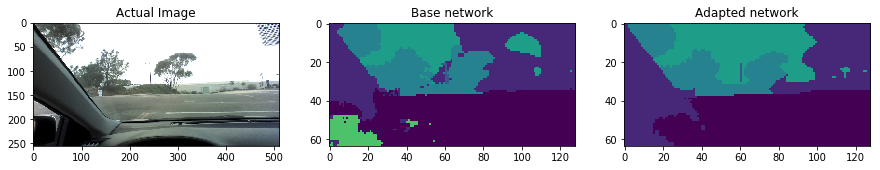

In [14]:
import matplotlib.pyplot as plt

img = img_loader.get_images(batch_size=1)
img = img.to(test_device)

op1 = base_network(img)
op2 = adapted_network(img)

fig_img1 = op1.detach().cpu().numpy().squeeze().argmax(axis=0)
fig_img2 = op2.detach().cpu().numpy().squeeze().argmax(axis=0)

# Ensure the color range is always same
fig_img1[0,0],fig_img1[0,1] = 0,18
fig_img2[0,0],fig_img2[0,1] = 0,18

img_trnsfm = transforms.ToPILImage()

plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(img_trnsfm(img.detach().cpu()[0]))
plt.title("Actual Image")

plt.subplot(1,3,2)
plt.imshow(fig_img1)
plt.title("Base network")

plt.subplot(1,3,3)
plt.imshow(fig_img2)
plt.title("Adapted network")
# plt.show()